In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pesq import pesq
import pystoi
import pandas as pd

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance, calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from data_generators import NoisyTargetWithMetricsGenerator
from sound import Sound
import tensorflow.keras.backend as K

from artigos.AttentionResUnet import AttentionResUnet

In [3]:
from keras.utils import custom_object_scope

In [4]:
base_shape_size = 8192
ws = 255
ol = 128

In [5]:
sound_base = Sound('/tf/Dados/Vozes/test/', '/tf/Dados/Ruido/test/', base_shape_size)

Loading Speech Files: 100%|██████████| 819/819 [00:01<00:00, 456.30it/s]
/tf/utils/sound.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:74: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]


In [6]:
def stft_to_signal(stft, sampling_rate=8000, window_size=ws, overlap=ol):
    A = stft[..., 0]
    phi = stft[..., 1]
    signal = reconstruct_signal_from_stft(A, phi, sampling_rate=sampling_rate, window_size=window_size, overlap=overlap)

    return signal

In [7]:
data_generator = NoisyTargetWithMetricsGenerator(sound_base.clean_sounds, sound_base.noise_sounds)

In [8]:
def process_batch(x_batch, y_batch, model):

    module = x_batch[:, :, :, 0].reshape(-1,128, 64, 1)
    phase = x_batch[:, :, :, 1].reshape(-1,128, 64, 1)
    
    stfts = model.predict(module, verbose=False)

    stfts = np.concatenate((stfts, phase), axis=3)
    # stfts = model.predict(x_batch, verbose=False)
    
    M, height, width, channels = stfts.shape  # Obtenha as dimensões do array de resultados do modelo

    pesq_scores = []
    stoi_scores = []
    snr_scores = []
    ID_scores = []

    for i in range(M):
        filtered = stfts[i, :, :, :]  # Obtenha o resultado do modelo para a iteração atual

        clean = y_batch[i, :, :, :]  # Obtenha o sinal limpo correspondente

        clean_signal = stft_to_signal(clean).reshape(-1)
        filtered_signal = stft_to_signal(filtered).reshape(-1)

        try:
            pesq_score = pesq(8000, clean_signal, filtered_signal, 'nb')
        except:
            pesq_score = 1.04
        stoi_score = pystoi.stoi(clean_signal, filtered_signal, 8000)
        snr_score = calculate_snr(clean_signal, filtered_signal)
        # ID_score = itakura_distortion(clean_signal, filtered_signal, 256, 11)

        pesq_scores.append(pesq_score)
        stoi_scores.append(stoi_score)
        snr_scores.append(snr_score)
        # ID_scores.append(ID_score)

    return pesq_scores, stoi_scores, snr_scores, ID_scores

In [9]:
batch_num = 50
df_resultado = pd.DataFrame()

In [10]:
# model = load_model('DNS-loss-0.0212-epochs-3-2023-11-11_21-09-11.h5')
# with custom_object_scope({'Convolutional_block': Convolutional_block,
#                           'Channel_attention': Channel_attention,
#                           'AttResUnetConvLSTM': AttResUnetConvLSTM,
#                           'Avg_pool_Unet_Upsample_msfe': Avg_pool_Unet_Upsample_msfe,
#                           'Multi_scale_feature_extraction': Multi_scale_feature_extraction,
                          # 'Kernel_selecting_module': Kernel_selecting_module}):
model = load_model('/tf/Etapa 3/Artigos/Attention ResU-Net/AttentionResUnet_checkpoints/attention_resunet_epochs_53_loss_mse_0.0106_vallos_0.0112.h5')
    # model = load_model('best_PRIDNet_0.0031_epochs_92.h5')

In [11]:
results = []

for _ in tqdm(range(batch_num)):
    (_, _), (x_batch, y_batch), metrics_batch_df = next(data_generator.generate_sample_completo(batch_size=128))
    results.append((process_batch(x_batch, y_batch, model),metrics_batch_df))

df_resultado = pd.DataFrame()

for result , metrics_batch_df in results:
    pesq_scores, stoi_scores, snr_scores, ID_scores = result
    metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    metrics_batch_df['STOI (Filtered)'] = stoi_scores
    metrics_batch_df['SNR (Filtered)'] = snr_scores
    # metrics_batch_df['ID (Filtered)'] = ID_scores
    
    df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

 68%|██████▊   | 34/50 [04:15<01:54,  7.17s/it]/usr/local/lib/python3.8/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
100%|██████████| 50/50 [06:11<00:00,  7.43s/it]


In [12]:
df_resultado

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
0,1.333927,0.679715,9.674240,2.208011,0.827522,7.059373
1,1.544599,0.787826,9.939692,2.640173,0.860495,8.285751
2,1.383193,0.769610,4.643165,2.036006,0.808368,5.565743
3,1.822309,0.897566,13.631542,2.995423,0.899921,14.262865
4,1.452880,0.687786,3.877707,2.381222,0.757841,9.372616
...,...,...,...,...,...,...
6383,1.816073,0.822968,4.770049,3.173133,0.836370,13.540636
6384,2.513786,0.903677,4.951801,3.568867,0.917251,13.604782
6385,2.415288,0.935573,3.978922,3.784801,0.963016,14.484531
6386,1.784335,0.844474,1.881836,3.624235,0.893677,14.066110


In [13]:
df_resultado.describe()

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
count,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000
mean,2.017010,0.836334,8.959982,2.913534,0.879322,12.100642
std,0.519772,0.132679,5.391708,0.571827,0.109222,4.202848
min,1.053569,-0.006263,-0.317405,1.040000,0.000010,0.910694
25%,1.622845,0.769662,3.989466,2.514149,0.837639,8.733727
50%,1.936265,0.871767,8.967236,2.939098,0.914215,11.814627
75%,2.312832,0.936782,13.432292,3.335665,0.954778,15.182542
max,4.360412,0.998942,29.001911,4.309383,0.997672,30.304978


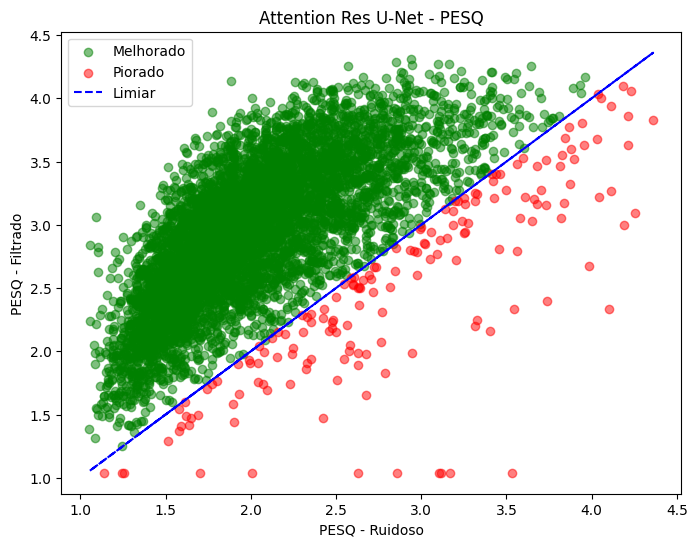

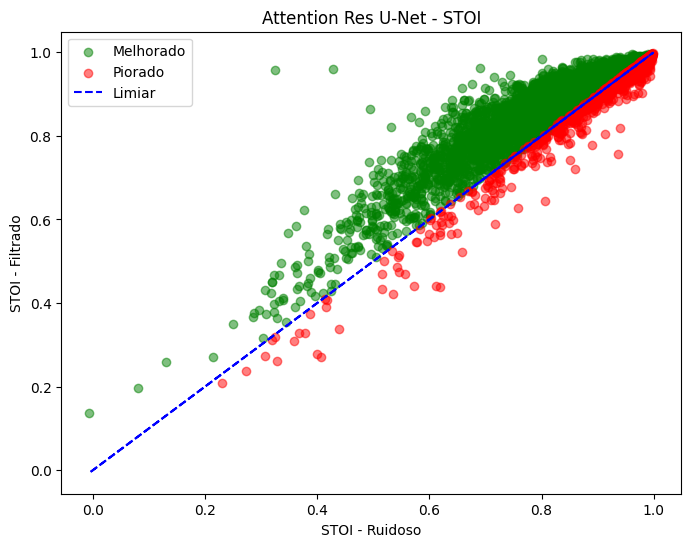

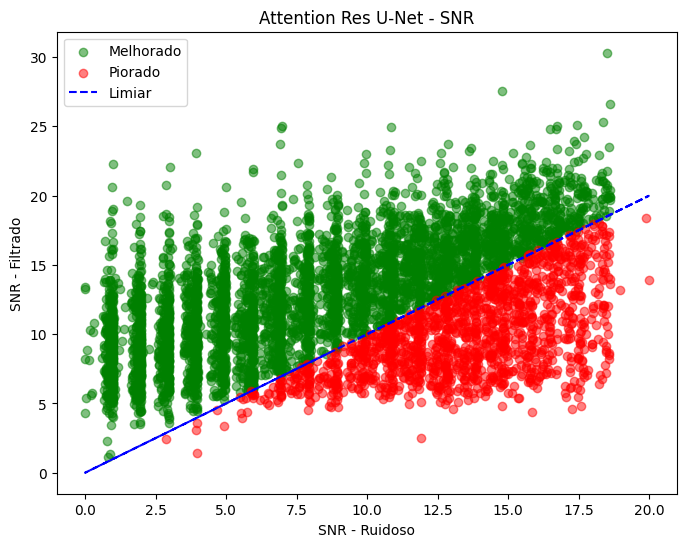

In [14]:
performance(df_resultado, 'Attention Res U-Net', snr_lte=20.)

In [17]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Define the file name with the datetime
file_name = f"attention_resunet_epochs_53_loss_mse_0.0106_vallos_0.0112_{datetime_str}.xlsx"

In [18]:
df_resultado.to_excel(file_name, index=False)